In [1]:
!pip install pandas_ta

In [2]:
import sys
sys.path.append('drive/MyDrive/Colab Notebooks/Trading Bot')
import pandas as pd
import numpy as np
from importlib import reload
import Utils.ML_usage as st
reload(st)
import Utils.Task_Evaluation as fnev
reload(fnev)
import Utils.Basic_ML_Eval as mlev
reload(mlev)
from sklearn.model_selection import train_test_split
import pandas_ta as ta

In [3]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/Trading Bot/Data/Crypto/SOL/SOLUSDT-5m-2022-2023-labeled")
df.index = pd.to_datetime(df["Date"])
df.drop(columns = ["Date"],inplace = True)
df.sort_index(inplace = True)
df.index = pd.to_datetime(df.index)
# df = df[df.index.date != pd.to_datetime('2023-03-24').date()]
# pct_change_columns = df.loc[:, df.columns != "Reversal"].pct_change()
# df.loc[:, df.columns != "Reversal"] = pct_change_columns

# Feature Extraction

In [4]:
OHLC = ["Open","Close","High","Low"]
def add_distances(feature,df):
   for price in OHLC:
        df[f"Absolute_{price}-{feature}"] = df[price] - df[f"Absolute_{feature}"]
        df[f"RelativeCL_{price}-{feature}"] = df[f"Absolute_{price}-{feature}"] / df["Close"]
        df[f"RelativeATR10_{price}-{feature}"] = df[f"Absolute_{price}-{feature}"] / df[f'Absolute_ATR_10']
        df[f"RelativeATR20_{price}-{feature}"] = df[f"Absolute_{price}-{feature}"] / df[f'Absolute_ATR_20']
def add_relative_features(feature,p,df):
  df[f'RelativeCL_{feature}'] = df[f'Absolute_{feature}'] / df["Close"]
  df[f'RelativeATR{p}_{feature}'] = df[f'Absolute_{feature}'] / df[f'Absolute_ATR_{p}']

def add_line_features(line,name,p,df):
    df[f"above_{name}_{p}"] = np.where(df['Low'] > line, 1, 0)
    df[f"below_{name}_{p}"] = np.where(df['High'] < line, 1, 0)
    df[f"through_{name}_{p}"] = np.where((df[f"above_{name}_{p}"] == 0) & (df[f"below_{name}_{p}"] == 0), 1, 0)

In [5]:
periods = [5,14,50,100]
def add_moving_averages(df):
    for p in periods:
        ma = df['Close'].rolling(window=p).mean()
        weights = np.arange(1, p+1)
        wma = df['Close'].rolling(window=p).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
        ema = df['Close'].ewm(span=p, adjust=False).mean()
        ema2 = ema.ewm(span=5, adjust=False).mean()
        ema3 = ema2.ewm(span=5, adjust=False).mean()
        tema = 3 * ema - 3 * ema2 + ema3
        moving_averages = [ma,wma,ema,ema2,ema3,tema]
        moving_averages_names = ["ma","wma","ema","ema2","ema3","tema"]
        for line,name in zip(moving_averages,moving_averages_names):
           add_line_features(line,name,p,df)

        # df[f'Absolute_MA_Close_{p}'] = df['Close'].rolling(window=p).mean()
        # weights = np.arange(1, p+1)
        # df[f'Absolute_WMA_Close_{p}'] = df['Close'].rolling(window=p).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
        # df[f'Absolute_EMA_Close_{p}'] = df['Close'].ewm(span=p, adjust=False).mean()
        # ema2 = df[f'Absolute_EMA_Close_{p}'].ewm(span=5, adjust=False).mean()
        # ema3 = ema2.ewm(span=5, adjust=False).mean()
        # df[f'Absolute_TEMA_Close_{p}'] = 3 * df[f'Absolute_EMA_Close_{p}'] - 3 * ema2 + ema3
        # moving_averages = [f"MA_Close_{p}",f"WMA_Close_{p}",f"EMA_Close_{p}",f"TEMA_Close_{p}"]
        # for ma in moving_averages:
        #   add_relative_features(ma,p,df)
        #   add_distances(ma, df)
    return df

def add_ATR(df):
   for p in periods:
      df[f'Absolute_ATR_{p}'] = ta.atr(df['High'], df['Low'], df['Close'],length = p)
      df[f'Relative_ATR_{p}'] = df[f'Absolute_ATR_{p}'] / df["Close"]
   return df

In [6]:
def preprocess_data(df):
    df = df.dropna()
    df = df.drop_duplicates()
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()
    df = df[df['Close'] != 0]
    df = df[df['Open'] != 0]
    return df

In [7]:
def extract_features(df):
   df_extracted = df.copy()
  #  df = add_ATR(df)
   df_extracted = add_moving_averages(df_extracted)
   df_extracted = preprocess_data(df_extracted)
   return df_extracted

In [8]:
df_extracted = extract_features(df)

In [9]:
X = df_extracted.drop(['Reversal'], axis=1)
y = df_extracted["Reversal"]

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def create_lagged_features(df, n_lags):
    new_df = df.copy()
    for col in df.columns:
        for i in range(1, n_lags+1):
            new_df[col + '_lag_' + str(i)] = df[col].shift(i)
    new_df = new_df.dropna()  # Drop rows with NaN values created by shifting
    return new_df

# Load your data into 'df' and set 'Date' as the index if it isn't already
lag = 4
X = create_lagged_features(X, lag)
y = y[-len(X):]

<ipython-input-10-a5b0cf21ee98>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[col + '_lag_' + str(i)] = df[col].shift(i)
<ipython-input-10-a5b0cf21ee98>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[col + '_lag_' + str(i)] = df[col].shift(i)
<ipython-input-10-a5b0cf21ee98>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def recursive_dimension_reduction(X, n_repeats=3):
    # Ensure the data is scaled
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the dataset to be used in the recursive process
    X_recursive = np.copy(X_scaled)

    for i in range(n_repeats):
            print(i)
            # Apply PCA
            pca = PCA(n_components=0.95)  # Retain 95% of variance
            X_pca = pca.fit_transform(X_recursive)

            # # Apply t-SNE
            # tsne = TSNE(n_components=3)  # Reduce to 2 components for visualization
            # X_tsne = tsne.fit_transform(X_recursive)

            # Merge the PCA and t-SNE results back with the original scaled data only during recursion
            if i < n_repeats - 1:
                X_recursive = np.hstack((X_scaled, X_pca))
            else:
                # On the final iteration, only return PCA and t-SNE features
                X_recursive = X_pca

    return X_recursive

X_transformed = recursive_dimension_reduction(X, n_repeats=3)
print("Transformed shape:", X_transformed.shape)

0
1
2
Transformed shape: (210211, 67)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.25, random_state=42,shuffle = False)

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def exc(X_train, X_test, y_train, y_test):
  params = {
      'objective': 'multi:softmax',
      'num_class': len(np.unique(y_train)),
      'max_depth': 5,
      'eta': 0.2,
      #'min_child_weight': 20,
     # 'scale_pos_weight': 6,
     # 'gamma': 0.1,
      'subsample': 0.5,
      'colsample_bytree': 0.5,
      'eval_metric': 'auc',
      'tree_method' : "hist", 'device' : "cuda"
  }

  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  num_rounds = 500
  evals = [(dtrain, 'train'), (dtest, 'eval')]
  model = xgb.train(params, dtrain, num_rounds, evals, verbose_eval=True)

  y_pred = model.predict(dtest)

  report = classification_report(y_test, y_pred)
  print("Classification Report:\n", report)

  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

  return model, y_pred

[0]	train-auc:0.55391	eval-auc:0.53345
[1]	train-auc:0.56337	eval-auc:0.54129
[2]	train-auc:0.56988	eval-auc:0.54375
[3]	train-auc:0.57485	eval-auc:0.54615
[4]	train-auc:0.57753	eval-auc:0.55010
[5]	train-auc:0.58087	eval-auc:0.55269
[6]	train-auc:0.58344	eval-auc:0.55236
[7]	train-auc:0.58604	eval-auc:0.55234
[8]	train-auc:0.58737	eval-auc:0.55234
[9]	train-auc:0.59028	eval-auc:0.55253
[10]	train-auc:0.59078	eval-auc:0.55279
[11]	train-auc:0.59142	eval-auc:0.55325
[12]	train-auc:0.59406	eval-auc:0.55372
[13]	train-auc:0.59610	eval-auc:0.55367
[14]	train-auc:0.59784	eval-auc:0.55425
[15]	train-auc:0.59921	eval-auc:0.55413
[16]	train-auc:0.60070	eval-auc:0.55392
[17]	train-auc:0.60217	eval-auc:0.55407
[18]	train-auc:0.60428	eval-auc:0.55405
[19]	train-auc:0.60522	eval-auc:0.55333
[20]	train-auc:0.60719	eval-auc:0.55325
[21]	train-auc:0.60885	eval-auc:0.55247
[22]	train-auc:0.61094	eval-auc:0.55231
[23]	train-auc:0.61250	eval-auc:0.55257
[24]	train-auc:0.61351	eval-auc:0.55214
[25]	train

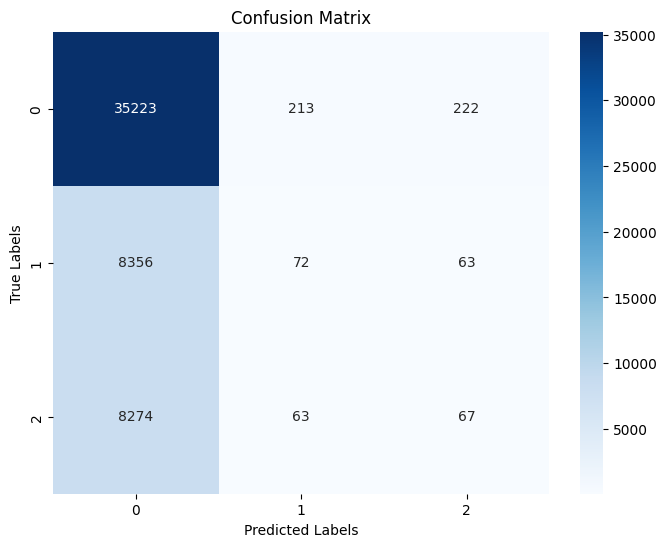

In [27]:
model, y_pred = exc(X_train, X_test, y_train, y_test)

In [ ]:
long_positions, short_positions = st.exc(pd.Series(y_pred), df.loc[y_test.index])


Estimation for: Return per trade
The 95% confidence interval of the observations is approximately from -0.60 to 0.80.



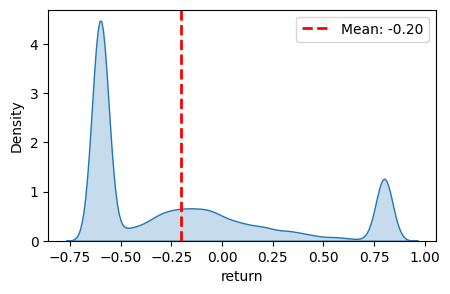


Estimation for: Return per day
The 95% confidence interval of the observations is approximately from -18.53 to -1.54.



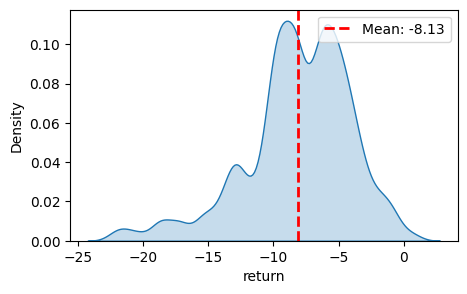


Estimation for: Exp return per day
The 95% confidence interval of the observations is approximately from -17.04 to -1.57.



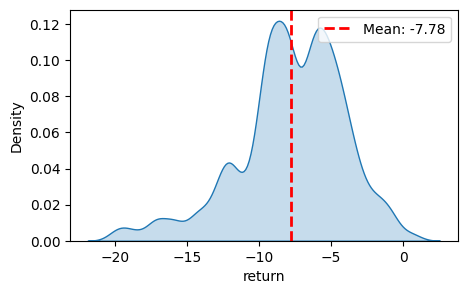


Estimation for: Return per week
The 95% confidence interval of the observations is approximately from -96.31 to -24.51.



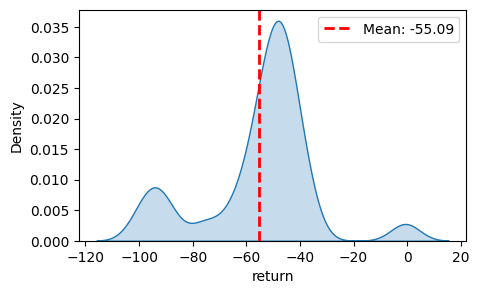


Estimation for: Exp return per week
The 95% confidence interval of the observations is approximately from -62.09 to -20.60.



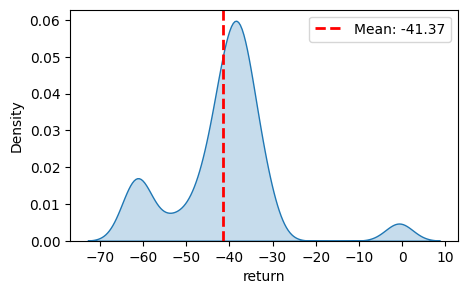


Estimation for: Return per month
The 95% confidence interval of the observations is approximately from -385.45 to -187.84.



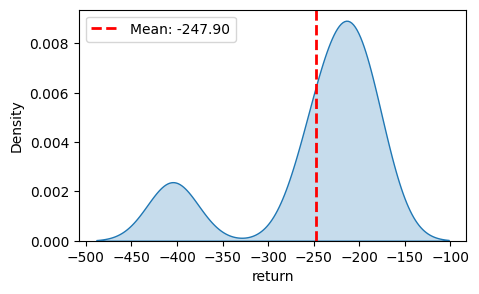


Estimation for: Exp return per month
The 95% confidence interval of the observations is approximately from -97.53 to -84.91.



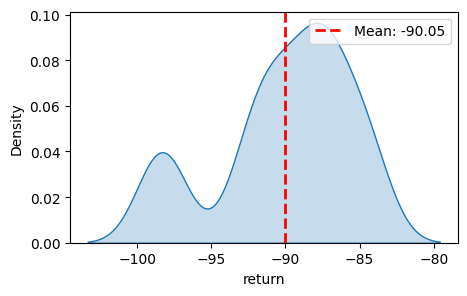

In [ ]:
fnev.exc(long_positions, short_positions, df.Open)